Should be signal in signal out.

In [1]:
# Helper functions
import numpy as np
import tensorflow as tf
from keras import layers
import keras as keras



# GENERATE DILATED LAYER FROM 1D SIGNAL
def signal_to_dilated(signal, dilation, n_channels):
    shape = tf.shape(signal)
    pad_elements = dilation - 1 - (shape[2] + dilation - 1) % dilation
    dilated = tf.pad(signal, [[0, 0], [0, 0], [0, pad_elements], [0, 0]])
    dilated = tf.reshape(dilated, [shape[0],-1,dilation,n_channels])
    return tf.transpose(dilated, perm=[0,2,1,3]), pad_elements


# COLLAPSE DILATED LAYER TO 1D SIGNAL
def dilated_to_signal(dilated, pad_elements, n_channels):
    shape = tf.shape(dilated)
    signal = tf.transpose(dilated, perm=[0,2,1,3])
    signal = tf.reshape(signal, [shape[0],1,-1,n_channels])
    return signal[:,:,:shape[1]*shape[2]-pad_elements,:]


# IDENTITY INITIALIZATION OF CONV LAYERS
def identity_initializer():
    def _initializer(shape, dtype=tf.float32, partition_info=None):
        array = np.zeros(shape, dtype=float)
        cx, cy = shape[0]//2, shape[1]//2
        for i in range(np.minimum(shape[2],shape[3])):
            array[cx, cy, i, i] = 1
        return tf.constant(array, dtype=dtype)
    return _initializer


# “In our experiments, simple training losses (e.g., L1) led to noticeably degraded output quality at lower signal-to-noise ratios (SNRs).” ([Germain et al., 2018, p. 2](zotero://select/library/items/A6D78SNY)) ([pdf](zotero://open-pdf/library/items/P4HPP4P3?page=2&annotation=DZN467TR))
def loss_function(target, current, type):
    if type == 'L1':
        return tf.reduce_mean(tf.abs(target-current))
    elif type == 'L2':
        return tf.reduce_mean(tf.square(target-current))

“receptive field of the pipeline is 2^14 + 1 samples, i.e., about 1 s of audio for fs = 16 kHz.” ([Germain et al., 2018, p. 2](zotero://select/library/items/A6D78SNY)) ([pdf](zotero://open-pdf/library/items/P4HPP4P3?page=2&annotation=WTGLQ8JQ))

In [2]:
# De-noising Network
import numpy as np
import tensorflow as tf
from keras import layers
class AdaptiveNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdaptiveNormalization, self).__init__(**kwargs)
        self.alpha = tf.Variable(1.0, name='alpha')
        self.beta = tf.Variable(0.0, name='beta')
        self.batch_norm = tf.keras.layers.BatchNormalization()
    def call(self, x):
        return self.alpha * x + self.beta * self.batch_norm(x)
# “point-wise nonlinear leaky rectified linear unit (LReLU) [28] max(0.2x, x)” 
# ([Germain et al., 2018, p. 2]
def LeakyReLU(x):
    return tf.maximum(0.2*x,x)

n_layers=7 # num of internal layers
n_channels=16 # number of feature maps (64 in paper)
norm_type="SBN"

if norm_type == "NM": # ADAPTIVE BATCH NORM
    norm_fn = AdaptiveNormalization
elif norm_type == "SBN": # BATCH NORM
    norm_fn = layers.BatchNormalization
else: # NO LAYER NORMALIZATION
    norm_fn = None
model_input = tf.keras.layers.Input(shape=(None, 1), dtype=tf.float32) # input is a single channel waveform (time, 1)
input = tf.expand_dims(model_input, axis=-1) # add a conv feature dimension (batch, time, 1, features)
input = tf.transpose(input, [0, 2, 1, 3]) # transpose to (batch, 1, time, features)
for current_layer in range(n_layers):
    if current_layer == 0:
        net = tf.keras.layers.Conv2D(n_channels, kernel_size=[1, 3], activation=LeakyReLU,name='se_conv_%d' % current_layer,padding='SAME')(input)
        net = norm_fn(name='se_norm_%d' % current_layer)(net)
    else:
        # The content of each intermediate layer is computed from the previous layer via a dilated convolution with 3 × 1 convolutional kernels
        # “Here, we increase the dilation factor exponentially with depth from 2^0 for the 1st intermediate layer to 2^12 for the 13th one.” ([Germain et al., 2018, p. 2])
        dilation_factor = 2 ** current_layer
        net, pad_elements = signal_to_dilated(net, n_channels=n_channels, dilation=dilation_factor)
        net = layers.Conv2D(n_channels, kernel_size=[1, 3], activation=LeakyReLU,name='se_conv_%d' % current_layer,padding='SAME')(net)
        net = norm_fn(name='se_norm_%d' % current_layer)(net)
        net = dilated_to_signal(net, n_channels=n_channels, pad_elements=pad_elements)
net = layers.Conv2D(n_channels, kernel_size=[1, 3], activation=LeakyReLU, name='se_conv_last', padding='SAME')(net)
net = norm_fn(name='se_norm_last')(net)
net = layers.Conv2D(1, kernel_size=[1, 1], activation=None,
                        name='se_fc_last', padding='SAME')(net)
# undo the transpose and squeeze the feature dimension
output = tf.squeeze(tf.transpose(net, [0, 2, 1, 3]), axis=-1)
model = keras.Model(inputs=model_input, outputs=output)
# model.summary()

In [21]:
import numpy as np
import os
os.environ['XLA_FLAGS'] = '--xla=false'
import tensorflow as tf
data_path = os.path.join(os.getcwd(),'data')
X = np.load(os.path.join(data_path, 'inputs_70_500_signal.npy'), allow_pickle=True)
X = tf.ragged.stack([tf.constant(x) for x in X], axis=0)
X = tf.expand_dims(X, axis=-1)

Y = np.load(os.path.join(data_path, 'targets_70_500_signal.npy'), allow_pickle=True)
Y = tf.ragged.stack([tf.constant(y) for y in Y], axis=0)
Y = tf.expand_dims(Y, axis=-1)
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(seed=70, buffer_size=500)
data_size = dataset.cardinality().numpy()
train_size = int(0.7 * data_size)

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
/device:GPU:0
Model loaded from:  c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model
Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045
Epoch 1: val_loss improved from inf to 0.00512, saving model to c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


350/350 [==============================] - 126s 355ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 2: val_loss improved from 0.00512 to 0.00416, saving model to c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


350/350 [==============================] - 125s 357ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/10
350/350 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 3: val_loss did not improve from 0.00416
350/350 [==============================] - 119s 339ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/10
350/350 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041
Epoch 4: val_loss improved from 0.00416 to 0.00407, saving model to c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


350/350 [==============================] - 123s 352ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/10
350/350 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041
Epoch 5: val_loss did not improve from 0.00407
350/350 [==============================] - 122s 349ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/10
350/350 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 6: val_loss did not improve from 0.00407
350/350 [==============================] - 118s 338ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/10
350/350 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041
Epoch 7: val_loss improved from 0.00407 to 0.00398, saving model to c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


INFO:tensorflow:Assets written to: c:\Users\Julio\Documents\Projects\audio-denoiser\saved\models\fcnn.model\assets


350/350 [==============================] - 121s 346ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 8/10
350/350 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 8: val_loss did not improve from 0.00398
350/350 [==============================] - 117s 335ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 9/10
350/350 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 9: val_loss did not improve from 0.00398
350/350 [==============================] - 120s 344ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 10/10
350/350 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041
Epoch 10: val_loss did not improve from 0.00398
350/350 [==============================] - 122s 349ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041


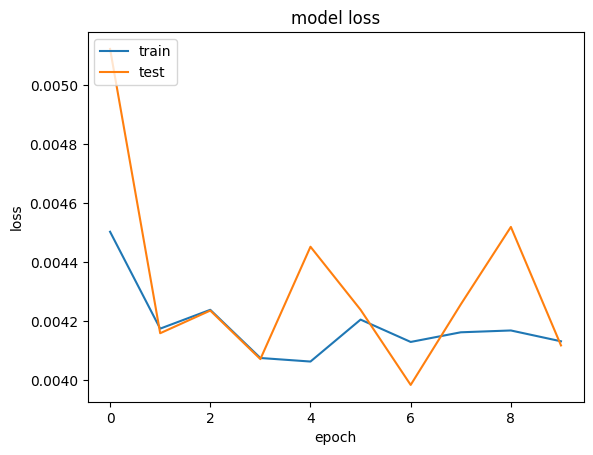

In [25]:
# A larger batch size can lead to faster training, but can also result in less accurate models. A smaller batch size can lead to slower training, but can also result in more accurate models.
# start at 64/128
# In general, you should start with a small number of epochs (e.g. 10-20) and increase the number of epochs until the model begins to overfit the training data. 
tf.debugging.set_log_device_placement(True)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

from keras import callbacks
import matplotlib.pyplot as plt
import os
SE_LOSS_LAYERS = 6 # NUMBER OF FEATURE LOSS LAYERS
model_path = os.path.join(os.getcwd(),'saved','models', 'fcnn.model')
if os.path.exists(model_path):
    model.load_weights(model_path)
    print('Model loaded from: ', model_path)
checkpoint = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False,mode='min')
stop = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=tf.keras.losses.MSE, optimizer=optimizer, metrics=['mse'])
# callbacks=[checkpoint, stop]
history = model.fit(train_set, epochs=10, validation_data=val_set, batch_size=64,callbacks=[checkpoint, stop],verbose=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
import librosa
import numpy as np
import IPython.display as ipd
demo_sample = X[10].numpy().squeeze()
demo_sample.shape
ipd.Audio(demo_sample, rate=16000)

“To compute the loss between two waveforms, we apply a pretrained audio classification network to each waveform and compare the internal activation patterns induced in the network by the two signals” ([Germain et al., 2018, p. 1](zotero://select/library/items/A6D78SNY)) ([pdf](zotero://open-pdf/library/items/P4HPP4P3?page=1&annotation=Y3F49L4C))

“The network consists of 15 convolutional layers with 3×1 kernels, batch normalization, LReLU units, and zero padding” ([Germain et al., 2018, p. 2](zotero://select/library/items/A6D78SNY)) ([pdf](zotero://open-pdf/library/items/P4HPP4P3?page=2&annotation=J3JNI54Q))


In [ ]:
# FEATURE LOSS NETWORK
import keras as keras
def LossNetwork(input):
    n_layers=14
    training=True
    reuse=False
    norm_type="SBN"
    # “The number of channels is doubled every 5 layers, with 32 channels in the first intermediate layer.” 
    base_channels=32
    doubling_rate=5
    conv_layers = []
    if norm_type == "NM": # ADAPTIVE BATCH NORM
        norm_fn = AdaptiveNormalization
    elif norm_type == "SBN": # BATCH NORM
        norm_fn = layers.BatchNormalization
    else: # NO LAYER NORMALIZATION
        norm_fn = None
        
    for current_layer in range(n_layers):
        n_channels = base_channels * (2 ** (current_layer // doubling_rate)) # UPDATE CHANNEL COUNT
        if current_layer == 0:
            # "Each Layer is decimated by 2" - just means stride of 2 in the time dimension.
            net = layers.Conv2D(input, n_channels, kernel_size=[1, 3], activation_fn=LeakyReLU, normalizer_fn=norm_fn, stride=[1, 2],
                              scope='loss_conv_%d' % current_layer, padding='SAME', reuse=reuse)
            conv_layers.append(net)
        elif current_layer < n_layers - 1:
            net = layers.Conv2D(conv_layers[-1], n_channels, kernel_size=[1, 3], activation_fn=LeakyReLU, normalizer_fn=norm_fn,
                              stride=[1, 2], scope='loss_conv_%d' % current_layer, padding='SAME', reuse=reuse)
            conv_layers.append(net)
        else:
            net = layers.Conv2D(conv_layers[-1], n_channels, kernel_size=[1, 3], activation_fn=LeakyReLU, normalizer_fn=norm_fn,
                              scope='loss_conv_%d' % current_layer, padding='SAME', reuse=reuse)
            conv_layers.append(net)
            # "Each channel in the last layer is averaged-pooled to produce the output ferature vector."

    return conv_layers


def featureloss(target, current, loss_weights, loss_layers, n_layers=14, norm_type="SBN", base_channels=32, blk_channels=5):

    feat_current = LossNetwork(current, reuse=False, n_layers=n_layers, norm_type=norm_type)

    feat_target = LossNetwork(target, reuse=True, n_layers=n_layers, norm_type=norm_type,
                         base_channels=base_channels, blk_channels=blk_channels)

    loss_vec = [0]
    #“The weights λm are set to balance the contribution of each layer to the loss. They are set to the inverse of the relative values of ‖Φm(ß) − Φm(g(x; θ))‖1 after 10 training epochs. (For these first 10 epochs, the weights are set to 1.)”
    for id in range(loss_layers):
        loss_vec.append(loss_function(feat_current[id], feat_target[id], type="L1") / loss_weights[id])
    # b) Denoising loss function:
    for id in range(1,loss_layers+1):
        loss_vec[0] += loss_vec[id]

    return loss_vec


In [ ]:
from keras import callbacks
import os

import sys, getopt

# Variables
SE_LAYERS = 13 # NUMBER OF INTERNAL LAYERS
SE_CHANNELS = 64 # NUMBER OF FEATURE CHANNELS PER LAYER
SE_LOSS_LAYERS = 6 # NUMBER OF FEATURE LOSS LAYERS
SE_NORM = "NM" # TYPE OF LAYER NORMALIZATION (NM, SBN or None)
SE_LOSS_TYPE = "FL" # TYPE OF TRAINING LOSS (L1, L2 or FL)

# FEATURE LOSS NETWORK
LOSS_LAYERS = 14 # NUMBER OF INTERNAL LAYERS
LOSS_BASE_CHANNELS = 32 # NUMBER OF FEATURE CHANNELS PER LAYER IN FIRT LAYER
LOSS_BLK_CHANNELS = 5 # NUMBER OF LAYERS BETWEEN CHANNEL NUMBER UPDATES
LOSS_NORM = "SBN" # TYPE OF LAYER NORMALIZATION (NM, SBN or None)


SET_WEIGHT_EPOCH = 10 # NUMBER OF EPOCHS BEFORE FEATURE LOSS BALANCE
SAVE_EPOCHS = 10 # NUMBER OF EPOCHS BETWEEN MODEL SAVES

log_file = open("logfile.txt", 'w+')

# COMMAND LINE OPTIONS
model_path = os.path.join('saved','models', 'fcnn.model')
loss_model_path = os.path.join('saved','models', 'floss.model')
data_path = os.path.join('data')
datafolder = "dataset"
modfolder = "models"
checkpoint = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,mode='min')
# try:
#     opts, args = getopt.getopt(sys.argv[1:],"hd:l:o:",["ifolder=,lossfolder=,outfolder="])
# except getopt.GetoptError:
#     print('Usage: python senet_infer.py -d <datafolder> -l <lossfolder> -o <outfolder>')
#     sys.exit(2)
# for opt, arg in opts:
#     if opt == '-h':
#         print ('Usage: python senet_infer.py -d <datafolder> -l <lossfolder> -o <outfolder>')
#         sys.exit()
#     elif opt in ("-d", "--datafolder"):
#         datafolder = arg
#     elif opt in ("-l", "--lossfolder"):
#         modfolder = arg
#     elif opt in ("-o", "--outfolder"):
#         outfolder = arg
# print( 'Data folder is "' + datafolder + '/"')
# print ('Loss model folder is "' + modfolder + '/"')
# print( 'Output model folder is "' + outfolder + '/"')

# SET LOSS FUNCTIONS AND PLACEHOLDERS
with tf.name_scope('loss_weights'):
    input_tensor = layers.Input(shape=(None, 1, None, 1), dtype=tf.float32)
    clean_tensor = layers.Input(shape=(None, 1, None, 1), dtype=tf.float32)
    # input=tf.placeholder(tf.float32,shape=[None,1,None,1])
    # clean=tf.placeholder(tf.float32,shape=[None,1,None,1])
        
    enhanced_tensor=senet(input_tensor, n_layers=SE_LAYERS, norm_type=SE_NORM, n_channels=SE_CHANNELS)
    # enhanced=senet(input, n_layers=SE_LAYERS, norm_type=SE_NORM, n_channels=SE_CHANNELS)
        
    if SE_LOSS_TYPE == "L1" or SE_LOSS_TYPE == "L2": # L1 LOSS
        # loss_weights = tf.placeholder(tf.float32, shape=[])
        loss_tensor = layers.Input(shape=None, dtype=tf.float32)
        loss_fn = loss_function(clean_tensor, enhanced_tensor, type=SE_LOSS_TYPE)
    else: # FEATURE LOSS
        # loss_weights = tf.placeholder(tf.float32, shape=[SE_LOSS_LAYERS])
        loss_tensor = layers.Input(shape=(SE_LOSS_LAYERS), dtype=tf.float32)
        # loss_fn = featureloss(clean, enhanced, loss_weights, loss_layers=SE_LOSS_LAYERS, n_layers=LOSS_LAYERS, norm_type=LOSS_NORM,
        #                          base_channels=LOSS_BASE_CHANNELS, blk_channels=LOSS_BLK_CHANNELS)
        
        loss_fn = featureloss(clean_tensor, enhanced_tensor, loss_tensor, loss_layers=SE_LOSS_LAYERS, n_layers=LOSS_LAYERS, norm_type=LOSS_NORM,
                                 base_channels=LOSS_BASE_CHANNELS, blk_channels=LOSS_BLK_CHANNELS)

# LOAD DATA
trainset, valset = load_full_data_list(datafolder = datafolder)
trainset, valset = load_full_data(trainset, valset)

# TRAINING OPTIMIZER
opt=tf.train.AdamOptimizer(learning_rate=1e-4).\
    minimize(loss_fn[0],var_list=[var for var in tf.trainable_variables() if var.name.startswith("se_")])
# As used in paper.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# BEGIN SCRIPT #########################################################################################################

# INITIALIZE GPU CONFIG
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
sess=tf.Session(config=config)

print ("Config ready")

sess.run(tf.global_variables_initializer())

print( "Session initialized")

# LOAD FEATURE LOSS
if SE_LOSS_TYPE == "FL":
    loss_saver = tf.train.Saver([var for var in tf.trainable_variables() if var.name.startswith("loss_")])
    loss_saver.restore(sess, "./%s/loss_model.ckpt" % modfolder)
    loss_train = np.zeros((len(trainset["innames"]),SE_LOSS_LAYERS+1))
    loss_val = np.zeros((len(valset["innames"]),SE_LOSS_LAYERS+1))
    loss_w = np.ones(SE_LOSS_LAYERS)
else:
    loss_train = np.zeros((len(trainset["innames"]),1))
    loss_val = np.zeros((len(valset["innames"]),1))
    loss_w = []
    
    
saver = tf.train.Saver([var for var in tf.trainable_variables() if var.name.startswith("se_")])
Nepochs = 320
#####################################################################################

for epoch in range(1,Nepochs+1):
    # TRAINING EPOCH ################################################################

    ids = np.random.permutation(len(trainset["innames"])) # RANDOM FILE ORDER

    for id in tqdm(range(0, len(ids)), file=sys.stdout):

        i = ids[id] # RANDOMIZED ITERATION INDEX
        inputData = trainset["inaudio"][i] # LOAD DEGRADED INPUT
        outputData = trainset["outaudio"][i] # LOAD GROUND TRUTH

        # TRAINING ITERATION
        _, loss_vec = sess.run([opt, loss_fn],
                                feed_dict={input: inputData, clean: outputData, loss_weights: loss_w})

        # SAVE ITERATION LOSS
        loss_train[id,0] = loss_vec[0]
        if SE_LOSS_TYPE == "FL":
            for j in range(SE_LOSS_LAYERS):
                loss_train[id,j+1] = loss_vec[j+1]

    # PRINT EPOCH TRAINING LOSS AVERAGE
    str = "T: %d\t " % (epoch)
    if SE_LOSS_TYPE == "FL":
        for j in range(SE_LOSS_LAYERS+1):
            str += ", %10.6e"%(np.mean(loss_train, axis=0)[j])
    else:
        str += ", %10.6e"%(np.mean(loss_train, axis=0)[0])

    log_file.write(str + "\n")
    log_file.flush()

    # SET WEIGHTS AFTER M EPOCHS
    if SE_LOSS_TYPE == "FL" and epoch == SET_WEIGHT_EPOCH:
        loss_w = np.mean(loss_train, axis=0)[1:]

    # SAVE MODEL EVERY N EPOCHS
    if epoch % SAVE_EPOCHS != 0:
        continue

    saver.save(sess, outfolder + "/se_model.ckpt")

    # VALIDATION EPOCH ##############################################################

    print("Validation epoch")

    for id in tqdm(range(0, len(valset["innames"])), file=sys.stdout):

        i = id # NON-RANDOMIZED ITERATION INDEX
        inputData = valset["inaudio"][i] # LOAD DEGRADED INPUT
        outputData = valset["outaudio"][i] # LOAD GROUND TRUTH

        # VALIDATION ITERATION
        output, loss_vec = sess.run([enhanced, loss_fn],
                            feed_dict={input: inputData, clean: outputData, loss_weights: loss_w})

        # SAVE ITERATION LOSS
        loss_val[id,0] = loss_vec[0]
        if SE_LOSS_TYPE == "FL":
            for j in range(SE_LOSS_LAYERS):
                loss_val[id,j+1] = loss_vec[j+1]

    # PRINT VALIDATION EPOCH LOSS AVERAGE
    str = "V: %d " % (epoch)
    if SE_LOSS_TYPE == "FL":
        for j in range(SE_LOSS_LAYERS+1):
            str += ", %10.6e"%(np.mean(loss_val, axis=0)[j]*1e9)
    else:
        str += ", %10.6e"%(np.mean(loss_val, axis=0)[0]*1e9)

    log_file.write(str + "\n")
    log_file.flush()

log_file.close()